In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import random
import time
from sklearn import manifold

#Building model
from keras.models import Sequential
from keras.layers import Dense

from keras import layers
from keras.models import Model

#Outlier method
from Outlier_Detection.pyod.pyod.models.abod import ABOD 


# 1. Pre-processing

In [8]:
input_path = "./CY_Dataset/2021_04_21_test/2021_04_21_test.csv"
output_path = "./CY_Dataset/2021_04_21_test/"

#設定顯示到小數點後第幾位 (可以不用設，實際還是保留原本長度，只是顯示上會變短)
#pd.options.display.float_format = '{:.16f}'.format

#讀檔 (header需設為 None，預設以 index 0 為欄位名稱)
data = pd.read_csv(input_path,header=None)

#自定義 欄位名稱
column = ["file_name","f_1","f_2","f_3","f_4","f_5","f_6","f_7","f_8","f_9","f_10","label"]
data.columns = column

#正規化 -> 把不是 0 (false) 的全部變成 1 (true)，並產生一個新的 csv 。
with open(output_path + "test_regular.csv", 'w', newline='') as csvfile:
    
    writer = csv.writer(csvfile)
    
    #寫入欄位名稱
    writer.writerow(column)  
    
    for i in range(len(data)):
        
        if(data["label"][i] != 0):         #找出不是 0 的 label 值
            
            data["label"][i] = 1

        writer.writerow(data.loc[i])


<ipython-input-8-1d2ee4f612d9>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["label"][i] = 1


# 2. Noisy Data

In [32]:
regularfile_path = "./CY_Dataset/2021_04_21_test/test_regular.csv" 
output_path = "./CY_Dataset/2021_04_21_test/"

noisy_data = pd.read_csv(regularfile_path) #讀取正規化後的 csv。

noisy_number = 3000 #要污染的數量。  
noisy_index = random.sample(range(0,len(noisy_data)),noisy_number) #取 samle_number 個不重複隨機數
print("noisy rate : %.5f"%(noisy_number/len(noisy_data)),end='\n') #顯示污染比例
print(noisy_index)
#反轉隨機 Sample 的 Label 值，並寫入 csv。
with open(output_path + "test_noisy.csv", 'w', newline='') as csvfile:
    
    writer = csv.writer(csvfile)
    
    #寫入欄位名稱
    writer.writerow(column)  
    
    for i in range(len(noisy_data)):
        
        if i in noisy_index:
            
            if(noisy_data["label"][i] == 0):         

                noisy_data["label"][i] = 1
                
            else:
            
                noisy_data["label"][i] = 0

        writer.writerow(noisy_data.loc[i])

noisy rate : 0.20631
[7826, 7346, 2285, 6219, 9557, 13009, 6169, 4162, 1466, 8162, 6925, 2626, 8859, 13922, 5956, 3114, 2113, 2503, 8325, 6912, 6457, 10626, 8772, 7997, 2755, 9697, 8014, 10639, 12654, 12443, 8979, 13981, 6856, 2954, 2921, 6806, 8756, 11903, 10982, 13034, 6871, 2337, 11510, 13427, 4635, 10374, 7849, 11725, 10573, 10243, 10530, 12535, 3316, 8888, 6926, 1470, 10748, 1853, 3187, 7777, 3509, 4931, 6805, 7302, 10221, 13524, 5541, 6917, 8691, 5844, 3527, 9640, 1187, 2404, 3064, 3492, 8876, 12942, 13399, 5657, 4156, 12128, 6490, 6107, 13601, 13478, 12210, 10301, 9089, 10558, 1756, 12675, 9052, 11563, 12211, 11428, 12538, 6281, 11921, 12588, 11520, 5543, 13161, 8621, 10090, 5694, 9179, 1077, 2323, 2346, 7478, 164, 1430, 11634, 5015, 10592, 9273, 7268, 7891, 12300, 10099, 3554, 2295, 8748, 3727, 6635, 13019, 3198, 11267, 136, 12524, 12030, 6585, 5615, 1251, 10590, 6462, 281, 5217, 12219, 6995, 3513, 13574, 5379, 10605, 5188, 14160, 9053, 1626, 2904, 11792, 11723, 7761, 4550, 904

<ipython-input-32-a7a488438cad>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noisy_data["label"][i] = 0
<ipython-input-32-a7a488438cad>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noisy_data["label"][i] = 1


# Function：WS and DS

In [33]:
def dataset(data):
    
    # Whole Set
    WS_x = data.drop(["file_name","label"], axis = 1)
    WS_y = data["label"]

    #----------------------------------------------------------------------

    # Downsampling Set
    sample_number = 10
    index = random.sample(range(0,len(WS_x)),sample_number)     #取 samle_number 個 不重複隨機數
    print(index)
    DS_x = WS_x.loc[index]
    DS_y = WS_y.loc[index]

    #----------------------------------------------------------------------

    # df -> np
    WS_x = WS_x.values
    WS_y = WS_y.values
 
    DS_x = DS_x.values
    DS_y = DS_y.values
    
    return (WS_x,WS_y,DS_x,DS_y)

# Function：Building Model

In [11]:
def build_model():
    
    model_input = layers.Input(shape=10)
    x = layers.Dense(500,activation='relu', kernel_initializer = 'normal')(model_input)
    x = layers.Dense(1000,activation='relu', kernel_initializer = 'normal')(x)
    model_output = layers.Dense(1,activation='softmax', kernel_initializer = 'normal')(x)
    
    return Model(model_input ,model_output)

# Function : Outlier Detection

In [12]:
def outlier_detection(loss):
    
    abod = ABOD().fit(loss)

    print(abod.decision_function(loss))
    

# Main - 前置動作

In [41]:
iteration = 1      #噪聲標籤檢測迭代次數
epoch = 50         #訓練次數

#第一次先載入原始檔案，之後每次迭代都會用 Reverse 過後的資料。
noisy_path = "./CY_Dataset/2021_04_21_test/test_noisy.csv" #Noisy data path
data = pd.read_csv(noisy_path) #取得已經增加 Noise 的 Data。

# Main - 進入迭代

In [42]:
start = time.time() #紀錄迭代開始的時間  
for i in range(iteration):  
    
    #每次迭代都要清空 Loss 值
    WS_loss = []
    DS_loss = []
    concatenate_loss = []
    
    #初始化 DS 大小的陣列，用來存 Loss 值 (不取值，只取 Sample 數)。
    for k in range(len(dataset(data)[2])): #k值用來處理 loss 迴圈
    
        WS_loss.append([])
        DS_loss.append([])
        concatenate_loss.append([])
    
    print("Iteration : %d"%(i+1))
    
    #Build_WS_model
    WS_model = build_model()
    WS_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #----------------------------------------------------------------------
    
    #Build_DS_model
    DS_model = build_model()
    DS_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #----------------------------------------------------------------------
    
    #抓取 Data Set
    train_data = dataset(data) #第一次迭代時的 Data 為還沒 Reverse 過的原始資料。
    WS_x = train_data[0]
    WS_y = train_data[1]
    DS_x = train_data[2]
    DS_y = train_data[3]
    #----------------------------------------------------------------------

    #Train_model
    for j in range(epoch):
       
        WS_model.fit(WS_x,WS_y,epochs = 1, batch_size = 10000 , verbose = 0)
        DS_model.fit(DS_x,DS_y,epochs = 1, batch_size = 1000 , verbose = 0)

        for k in range(len(DS_x)): #k值用來處理 loss 迴圈

            loss_x = DS_x[k].reshape(1,10)
            loss_y = DS_y[k].reshape(1,1)

            #取出 loss 值
            WS_loss[k].append(WS_model.evaluate(loss_x,loss_y,verbose=0)[0])
            DS_loss[k].append(DS_model.evaluate(loss_x,loss_y,verbose=0)[0])
        
        print("\n Epoch : %d ..."%(j+1),end="\n")
    #----------------------------------------------------------------------
    
    #合併 Loss 值
    for k in range(len(DS_x)): #k值用來處理 loss 迴圈
        
        concatenate_loss[k] = WS_loss[k] + DS_loss[k] 
    
    #----------------------------------------------------------------------
    
    #Outlier_detection (使用剛剛收集 DS 中每個 Sample 的 Loss 值)
    outlier_detection(concatenate_loss)
    
    
    
    
    #----------------------------------------------------------------------
    
    #Reverse_label
    
    
    
    #----------------------------------------------------------------------
    
#處理結束
end = time.time()
print()
print("Total time : %8f s"%(end-start),end="\n")

[6444, 10317, 6458, 3092, 7915, 14523, 8302, 4414, 8749, 1124]
Iteration : 1
[11298, 7319, 9120, 3628, 6388, 7678, 2396, 14333, 713, 10560]

 Epoch : 1 ...

 Epoch : 2 ...

 Epoch : 3 ...

 Epoch : 4 ...

 Epoch : 5 ...

 Epoch : 6 ...

 Epoch : 7 ...

 Epoch : 8 ...

 Epoch : 9 ...

 Epoch : 10 ...

 Epoch : 11 ...

 Epoch : 12 ...

 Epoch : 13 ...

 Epoch : 14 ...

 Epoch : 15 ...

 Epoch : 16 ...

 Epoch : 17 ...

 Epoch : 18 ...

 Epoch : 19 ...

 Epoch : 20 ...

 Epoch : 21 ...

 Epoch : 22 ...

 Epoch : 23 ...

 Epoch : 24 ...

 Epoch : 25 ...

 Epoch : 26 ...

 Epoch : 27 ...

 Epoch : 28 ...

 Epoch : 29 ...

 Epoch : 30 ...

 Epoch : 31 ...

 Epoch : 32 ...

 Epoch : 33 ...

 Epoch : 34 ...

 Epoch : 35 ...

 Epoch : 36 ...

 Epoch : 37 ...

 Epoch : 38 ...

 Epoch : 39 ...

 Epoch : 40 ...

 Epoch : 41 ...

 Epoch : 42 ...

 Epoch : 43 ...

 Epoch : 44 ...

 Epoch : 45 ...

 Epoch : 46 ...

 Epoch : 47 ...

 Epoch : 48 ...

 Epoch : 49 ...

 Epoch : 50 ...
[-9.69930294e-07 -7

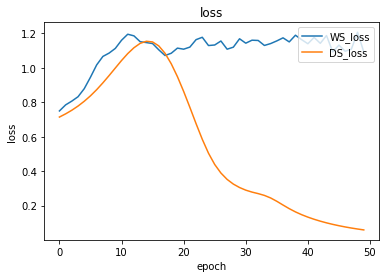

In [52]:
plt.plot(WS_loss[0])
plt.plot(DS_loss[0])
#plt.plot(concatenate_loss[0])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["WS_loss","DS_loss","con_loss"], loc='upper right') 
plt.show()


In [156]:
loss = history.history["loss"]
print(loss)
loss = np.asarray(loss)
loss = loss.reshape(-1,1)

abod = ABOD().fit(loss)

print(abod.decision_function(loss))

NameError: name 'history' is not defined